# Downloading the Dataset

Uncomment the code below to download the CIFAR10 dataset.

In [1]:
# import torchvision.datasets as datasets

# # This command automatically downloads and loads the training data
# trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Loading Model

In [19]:
BASELINE_MODEL_PATH = f'saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198_best.pth'

In [20]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict
import os
from train_early_stopping import create_mobilenetv2_from_scratch, load_model_weights

# Define the path to your saved model
BASELINE_MODEL_PATH = './saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198_best.pth'

# Define your device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the model architecture
baseline_model = create_mobilenetv2_from_scratch(num_classes=10).to(device)

# Use your helper function to load the weights
baseline_model = load_model_weights(baseline_model, BASELINE_MODEL_PATH)

Loading previous model weights from: ./saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198_best.pth
  -> Adjusting keys for non-DataParallel model by removing 'module.' prefix.


Training history successfully loaded.

Plot saved to: ./plots/baseline_history_plot.png


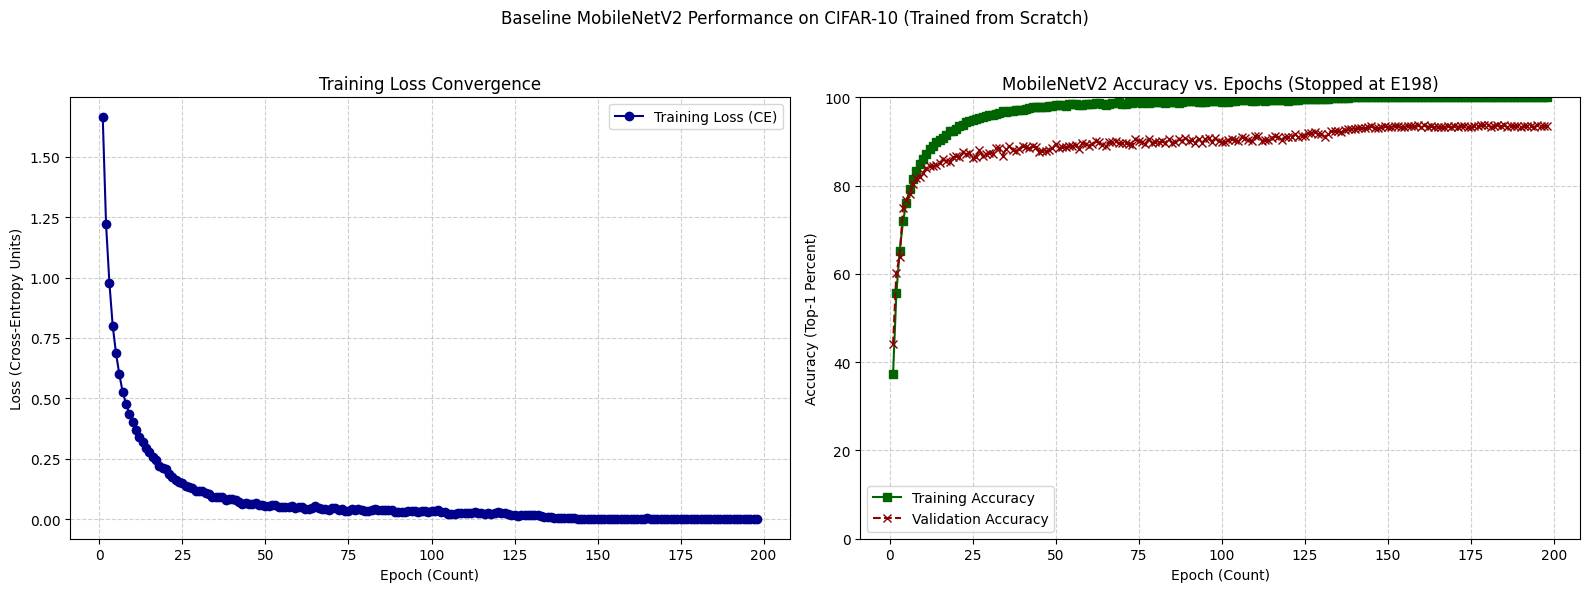

In [21]:
import pickle
import matplotlib.pyplot as plt

# --- Configuration (MUST MATCH your saved file) ---
FINAL_EPOCHS_TRAINED = 24 # Must match the actual final epoch count
HISTORY_PATH = f'./saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198.pkl'
# ----------------------------------------------------

# 1. Load the history dictionary
try:
    with open(HISTORY_PATH, 'rb') as f:
        history = pickle.load(f)
    print("Training history successfully loaded.")
except FileNotFoundError:
    print(f"Error: History file not found at {HISTORY_PATH}")
    exit()

# 2. Extract data and create plots
# Get the number of epochs actually trained (due to early stopping)
epochs = range(1, len(history['train_loss']) + 1)

# Per user request: Color-blind friendly, named axes, units, legend, title, and description.

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Loss Curve ---
ax1.plot(epochs, history['train_loss'], 
         label='Training Loss (CE)', 
         color='darkblue', 
         marker='o', 
         linestyle='-')
ax1.set_title('Training Loss Convergence')
ax1.set_xlabel('Epoch (Count)')
ax1.set_ylabel('Loss (Cross-Entropy Units)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# --- Plot 2: Accuracy Curves ---
# Note: Using distinct markers and lines for color-challenged audience
ax2.plot(epochs, history['train_acc'], 
         label='Training Accuracy', 
         color='darkgreen', 
         marker='s', 
         linestyle='-')
ax2.plot(epochs, history['valid_acc'], 
         label='Validation Accuracy', 
         color='darkred', 
         marker='x', 
         linestyle='--')
ax2.set_title(f'MobileNetV2 Accuracy vs. Epochs (Stopped at E{len(epochs)})')
ax2.set_xlabel('Epoch (Count)')
ax2.set_ylabel('Accuracy (Top-1 Percent)')
ax2.set_ylim(0, 100) # Ensure y-axis is in Percent
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# Main Title and Description (Required for self-explanatory plot)
fig.suptitle(f'Baseline MobileNetV2 Performance on CIFAR-10 (Trained from Scratch)')
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the plot for inclusion in your PDF report
PLOT_FILENAME = './plots/baseline_history_plot.png'
plt.savefig(PLOT_FILENAME)
print(f"\nPlot saved to: {PLOT_FILENAME}")
plt.show()

# Pruning

In [22]:
from prune import apply_pruning_to_model
from train_early_stopping import evaluate_model, load_and_prepare_data
from prune import verify_comparative_sparsity

In [23]:
BATCH_SIZE = 32      
INPUT_SIZE = 224      
VALID_SPLIT_RATIO = 0.1 # 10% of the training data will be used for validation
MANUAL_SEED = 42

In [24]:
train_loader, validation_loader, test_loader = load_and_prepare_data(
    INPUT_SIZE, BATCH_SIZE, VALID_SPLIT_RATIO, MANUAL_SEED
)

Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)


Below, we take the baseline model and analyze various levels of pruning to see the performance of the model after pruning.

In [10]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 198 # Use the actual number from your saved file
MODEL_PATH = BASELINE_MODEL_PATH
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
# sparsity_targets = [0.20, 0.30, 0.40, 0.50]
sparsity_targets = [0.40]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

TEMP_SAVE_PATH = './saved_models/temp'
os.makedirs(TEMP_SAVE_PATH, exist_ok=True)

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning = baseline_model
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    sparsity_percent = sparsity * 100
    save_filename = f'pruned_{sparsity_percent:.0f}pc_untuned.pth'
    full_save_path = os.path.join(TEMP_SAVE_PATH, save_filename)
    
    # The infinite of the verb is to save.
    torch.save(model_for_pruning.state_dict(), full_save_path)
    print(f"Saved temporary pruned model to: {full_save_path}")

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 40.0%) ---
Pruned Conv2d | Target: 40.0%, Actual: 40.28%, Threshold: 0.026490
Pruned Conv2d | Target: 40.0%, Actual: 40.04%, Threshold: 0.029055
Pruned Conv2d | Target: 40.0%, Actual: 40.04%, Threshold: 0.018847
Pruned Conv2d | Target: 40.0%, Actual: 40.05%, Threshold: 0.013566
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.021674
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.012470
Pruned Conv2d | Target: 40.0%, Actual: 40.05%, Threshold: 0.013660
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.020569
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.015099
Pruned Conv2d | Target: 40.0%, Actual: 40.05%, Threshold: 0.019016
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.018448
Pruned Conv2d | Target: 40.0%, Actual: 40.01%, Threshold: 0.011306
Pruned Conv2d | Target: 40.0%, Actual: 40.05%, Threshold: 0.017192
Pruned Conv2d | Target: 40.0%, 

From the above cell, we can see that we're able to prune 20% of the weights without significant loss in accuracy while not retraining the model.

We will however choose to prune by sparsity of 40% and then tune the model to observe the results using the script ```fine_tune.py```.

In [107]:
!python3 fine_tune.py --epochs 10 --batch_size 32 --lr 1e-4 --patience 3 --log_interval 500 --pruning_sparsity 0.4 --load_path "./saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198_best.pth" --total_epochs_prior 198

Random seed set to 42
Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)
Loading previous model weights from: ./saved_models/from_kaggle/mobilenetv2_baseline_lr1e-02_e198_best.pth
  -> Adjusting keys for non-DataParallel model by removing 'module.' prefix.
Applying pruning with target sparsity: 40.00%

--- Applying Pruning (Sparsity Target: 40.0%) ---
Pruned Conv2d | Target: 40.0%, Actual: 40.28%, Threshold: 0.026490
Pruned Conv2d | Target: 40.0%, Actual: 40.04%, Threshold: 0.029055
Pruned Conv2d | Target: 40.0%, Actual: 40.04%, Threshold: 0.018847
Pruned Conv2d | Target: 40.0%, Actual: 40.05%, Threshold: 0.013566
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.021674
Pruned Conv2d | Target: 40.0%, Actual: 40.02%, Threshold: 0.012470
Pruned Conv2d | Tar

In [ ]:
from prune import calculate_absolute_sparsity

# --- 1. Define the file path to save your model ---
# PRUNED_MODEL_PATH = './saved_models/temp/pruned_40pc_untuned.pth'
PRUNED_MODEL_PATH = './saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth'

# --- 2. Call the function directly with the file path ---
print(f"Calculating metrics for model at: {PRUNED_MODEL_PATH}")                                                                                                                                                 
baseline_sparsity_results = calculate_absolute_sparsity(pruned_path=BASELINE_MODEL_PATH)
pruned_sparsity_results = calculate_absolute_sparsity(pruned_path=PRUNED_MODEL_PATH)

# --- 3. Print the results ---
if "error" in baseline_sparsity_results:
    print(f"An error occurred: {baseline_sparsity_results['error']}")
else:
    baseline_sparsity_percent = baseline_sparsity_results['absolute_sparsity'] * 100
    baseline_compression = baseline_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {baseline_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {baseline_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {baseline_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {baseline_compression:.2f}x")

if "error" in pruned_sparsity_results:
    print(f"An error occurred: {pruned_sparsity_results['error']}")
else:
    pruned_sparsity_percent = pruned_sparsity_results['absolute_sparsity'] * 100
    pruned_compression = pruned_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {pruned_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {pruned_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {pruned_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {pruned_compression:.2f}x")

Calculating metrics for model at: ./saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 119
Absolute Sparsity: 0.01%
Weight Compression Ratio: 1.00x

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 880,726
Absolute Sparsity: 39.38%
Weight Compression Ratio: 1.65x


In [12]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, PRUNED_MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 92.75%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy: 92.75%


We can see that after pruning to 60% of the size (40% sparsity), we obtain 92.75% accuracy, which is a 0.11% drop in accuracy. Let's try to prune further.

So we have a total of 1,355,956 non-zero parameters. 

We have a total of 2,236,682 parameters, which means that if we represent each weight by a unique number lower than that, each weight will need 22 bits. This gives us the overhead as about 1.82 mB. 5.17 mB will be used for storing the 1,355,956 non-zero values in FP32. Total of 6.99 mB.

In [13]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 207 # Use the actual number from your saved file
MODEL_PATH = PRUNED_MODEL_PATH
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.45, 0.50]
# sparsity_targets = [0.4]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

TEMP_SAVE_PATH = './saved_models/temp'
os.makedirs(TEMP_SAVE_PATH, exist_ok=True)

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning = final_pruned_model
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # sparsity_percent = sparsity * 100
    # save_filename = f'pruned_{sparsity_percent:.0f}pc_untuned.pth'
    # full_save_path = os.path.join(TEMP_SAVE_PATH, save_filename)
    
    # # The infinite of the verb is to save.
    # torch.save(model_for_pruning.state_dict(), full_save_path)
    # print(f"Saved temporary pruned model to: {full_save_path}")

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 40.28%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.04%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.04%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.05%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.05%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.05%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.01%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 40.05%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, 

In [131]:
!python3 fine_tune.py --epochs 10 --batch_size 32 --lr 5e-5 --patience 3 --log_interval 500 --pruning_sparsity 0.47 --load_path "./saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth" --total_epochs_prior 207

Random seed set to 42
Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)
Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth
Applying pruning with target sparsity: 47.00%

--- Applying Pruning (Sparsity Target: 47.0%) ---
Pruned Conv2d | Target: 47.0%, Actual: 47.22%, Threshold: 0.030860
Pruned Conv2d | Target: 47.0%, Actual: 47.07%, Threshold: 0.034881
Pruned Conv2d | Target: 47.0%, Actual: 47.01%, Threshold: 0.021458
Pruned Conv2d | Target: 47.0%, Actual: 47.11%, Threshold: 0.016912
Pruned Conv2d | Target: 47.0%, Actual: 47.01%, Threshold: 0.025598
Pruned Conv2d | Target: 47.0%, Actual: 47.02%, Threshold: 0.014781
Pruned Conv2d | Target: 47.0%, Actual: 47.07%, Threshold: 0.016073
Pruned Conv

In [14]:
from prune import calculate_absolute_sparsity

# --- 1. Define the file path to save your model ---
# PRUNED_MODEL_PATH = './saved_models/temp/pruned_40pc_untuned.pth'
PRUNED_MODEL_PATH = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth'

# --- 2. Call the function directly with the file path ---
print(f"Calculating metrics for model at: {PRUNED_MODEL_PATH}")
baseline_sparsity_results = calculate_absolute_sparsity(pruned_path=BASELINE_MODEL_PATH)
pruned_sparsity_results = calculate_absolute_sparsity(pruned_path=PRUNED_MODEL_PATH)

# --- 3. Print the results ---
if "error" in baseline_sparsity_results:
    print(f"An error occurred: {baseline_sparsity_results['error']}")
else:
    baseline_sparsity_percent = baseline_sparsity_results['absolute_sparsity'] * 100
    baseline_compression = baseline_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {baseline_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {baseline_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {baseline_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {baseline_compression:.2f}x")

if "error" in pruned_sparsity_results:
    print(f"An error occurred: {pruned_sparsity_results['error']}")
else:
    pruned_sparsity_percent = pruned_sparsity_results['absolute_sparsity'] * 100
    pruned_compression = pruned_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {pruned_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {pruned_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {pruned_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {pruned_compression:.2f}x")

Calculating metrics for model at: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 119
Absolute Sparsity: 0.01%
Weight Compression Ratio: 1.00x

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 1,034,840
Absolute Sparsity: 46.27%
Weight Compression Ratio: 1.86x


In [15]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, PRUNED_MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 92.26%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy: 92.26%


We can see that after pruning to 53.73% of the size (46.27% sparsity), we obtain 92.26% accuracy, which is a 0.60% drop in accuracy. Let's try to prune further.

So we have a total of 1,201,842 non-zero parameters. 

We have a total of 2,236,682 parameters, which means that if we represent each weight by a unique number lower than that, each weight will need 22 bits. This gives us the overhead as about 1.82 mB. 4.58 mB will be used for storing the 1,355,956 non-zero values in FP32. Total of 6.40 mB.

In [16]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 207 # Use the actual number from your saved file
MODEL_PATH = PRUNED_MODEL_PATH
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.20, 0.30, 0.40, 0.45, 0.50, 0.55, 0.60]
# sparsity_targets = [0.4]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

TEMP_SAVE_PATH = './saved_models/temp'
os.makedirs(TEMP_SAVE_PATH, exist_ok=True)

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning = final_pruned_model
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # sparsity_percent = sparsity * 100
    # save_filename = f'pruned_{sparsity_percent:.0f}pc_untuned.pth'
    # full_save_path = os.path.join(TEMP_SAVE_PATH, save_filename)
    
    # # The infinite of the verb is to save.
    # torch.save(model_for_pruning.state_dict(), full_save_path)
    # print(f"Saved temporary pruned model to: {full_save_path}")

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 20.0%) ---
Pruned Conv2d | Target: 20.0%, Actual: 47.22%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.07%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.01%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.11%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.01%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.07%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.02%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.07%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.01%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.01%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, Actual: 47.05%, Threshold: 0.000000
Pruned Conv2d | Target: 20.0%, 

In [136]:
!python3 fine_tune.py --epochs 10 --batch_size 32 --lr 5e-5 --patience 3 --log_interval 500 --pruning_sparsity 0.55 --load_path "./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth" --total_epochs_prior 217

Random seed set to 42
Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)
Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth
Applying pruning with target sparsity: 55.00%

--- Applying Pruning (Sparsity Target: 55.0%) ---
Pruned Conv2d | Target: 55.0%, Actual: 55.21%, Threshold: 0.037869
Pruned Conv2d | Target: 55.0%, Actual: 55.08%, Threshold: 0.041576
Pruned Conv2d | Target: 55.0%, Actual: 55.01%, Threshold: 0.025730
Pruned Conv2d | Target: 55.0%, Actual: 55.09%, Threshold: 0.020241
Pruned Conv2d | Target: 55.0%, Actual: 55.03%, Threshold: 0.031146
Pruned Conv2d | Target: 55.0%, Actual: 55.01%, Threshold: 0.017779
Pruned Conv2d | Target: 55.0%, Actual: 55.02%, T

In [17]:
from prune import calculate_absolute_sparsity

# --- 1. Define the file path to save your model ---
# PRUNED_MODEL_PATH = './saved_models/temp/pruned_40pc_untuned.pth'
PRUNED_MODEL_PATH = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth'

# --- 2. Call the function directly with the file path ---
print(f"Calculating metrics for model at: {PRUNED_MODEL_PATH}")
baseline_sparsity_results = calculate_absolute_sparsity(pruned_path=BASELINE_MODEL_PATH)
pruned_sparsity_results = calculate_absolute_sparsity(pruned_path=PRUNED_MODEL_PATH)

# --- 3. Print the results ---
if "error" in baseline_sparsity_results:
    print(f"An error occurred: {baseline_sparsity_results['error']}")
else:
    baseline_sparsity_percent = baseline_sparsity_results['absolute_sparsity'] * 100
    baseline_compression = baseline_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {baseline_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {baseline_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {baseline_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {baseline_compression:.2f}x")

if "error" in pruned_sparsity_results:
    print(f"An error occurred: {pruned_sparsity_results['error']}")
else:
    pruned_sparsity_percent = pruned_sparsity_results['absolute_sparsity'] * 100
    pruned_compression = pruned_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {pruned_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {pruned_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {pruned_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {pruned_compression:.2f}x")

Calculating metrics for model at: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 119
Absolute Sparsity: 0.01%
Weight Compression Ratio: 1.00x

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 1,210,978
Absolute Sparsity: 54.14%
Weight Compression Ratio: 2.18x


In [18]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, PRUNED_MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 91.52%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy: 91.52%


We can see that after pruning to 45.86% of the size (54.14% sparsity), we obtain 91.52% accuracy, which is a 1.34% drop in accuracy. Let's try to prune further.

So we have a total of 1,025,704 non-zero parameters. 

We have a total of 2,236,682 parameters, which means that if we represent each weight by a unique number lower than that, each weight will need 22 bits. This gives us the overhead as about 1.82 mB. 3.91 mB will be used for storing the 1,355,956 non-zero values in FP32. Total of 5.73 mB.

In [19]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 207 # Use the actual number from your saved file
MODEL_PATH = PRUNED_MODEL_PATH
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.40, 0.45, 0.50, 0.55, 0.60, 0.65]
# sparsity_targets = [0.4]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

TEMP_SAVE_PATH = './saved_models/temp'
os.makedirs(TEMP_SAVE_PATH, exist_ok=True)

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning = final_pruned_model
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # sparsity_percent = sparsity * 100
    # save_filename = f'pruned_{sparsity_percent:.0f}pc_untuned.pth'
    # full_save_path = os.path.join(TEMP_SAVE_PATH, save_filename)
    
    # # The infinite of the verb is to save.
    # torch.save(model_for_pruning.state_dict(), full_save_path)
    # print(f"Saved temporary pruned model to: {full_save_path}")

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 40.0%) ---
Pruned Conv2d | Target: 40.0%, Actual: 55.21%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.08%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.09%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.03%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.02%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.02%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.01%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, Actual: 55.03%, Threshold: 0.000000
Pruned Conv2d | Target: 40.0%, 

In [140]:
!python3 fine_tune.py --epochs 10 --batch_size 32 --lr 5e-5 --patience 5 --log_interval 500 --pruning_sparsity 0.6 --load_path "./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth" --total_epochs_prior 223

Random seed set to 42
Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)
Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth
Applying pruning with target sparsity: 60.00%

--- Applying Pruning (Sparsity Target: 60.0%) ---
Pruned Conv2d | Target: 60.0%, Actual: 60.07%, Threshold: 0.042816
Pruned Conv2d | Target: 60.0%, Actual: 60.16%, Threshold: 0.046383
Pruned Conv2d | Target: 60.0%, Actual: 60.03%, Threshold: 0.028753
Pruned Conv2d | Target: 60.0%, Actual: 60.07%, Threshold: 0.022559
Pruned Conv2d | Target: 60.0%, Actual: 60.03%, Threshold: 0.035094
Pruned Conv2d | Target: 60.0%, Actual: 60.01%, Threshold: 0.019901
Pruned Conv2d | Ta

In [20]:
from prune import calculate_absolute_sparsity

# --- 1. Define the file path to save your model ---
# PRUNED_MODEL_PATH = './saved_models/temp/pruned_40pc_untuned.pth'
PRUNED_MODEL_PATH = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth'

# --- 2. Call the function directly with the file path ---
print(f"Calculating metrics for model at: {PRUNED_MODEL_PATH}")
baseline_sparsity_results = calculate_absolute_sparsity(pruned_path=BASELINE_MODEL_PATH)
pruned_sparsity_results = calculate_absolute_sparsity(pruned_path=PRUNED_MODEL_PATH)

# --- 3. Print the results ---
if "error" in baseline_sparsity_results:
    print(f"An error occurred: {baseline_sparsity_results['error']}")
else:
    baseline_sparsity_percent = baseline_sparsity_results['absolute_sparsity'] * 100
    baseline_compression = baseline_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {baseline_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {baseline_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {baseline_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {baseline_compression:.2f}x")

if "error" in pruned_sparsity_results:
    print(f"An error occurred: {pruned_sparsity_results['error']}")
else:
    pruned_sparsity_percent = pruned_sparsity_results['absolute_sparsity'] * 100
    pruned_compression = pruned_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {pruned_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {pruned_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {pruned_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {pruned_compression:.2f}x")

Calculating metrics for model at: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 119
Absolute Sparsity: 0.01%
Weight Compression Ratio: 1.00x

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 1,321,049
Absolute Sparsity: 59.06%
Weight Compression Ratio: 2.44x


In [21]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, PRUNED_MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 91.56%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy: 91.56%


We can see that after pruning to 40.94% of the size (59.06% sparsity), we obtain 91.56% accuracy, which is a 1.30% drop in accuracy. Let's try to prune further.

So we have a total of 915,633 non-zero parameters. 

We have a total of 2,236,682 parameters, which means that if we represent each weight by a unique number lower than that, each weight will need 22 bits. This gives us the overhead as about 1.82 mB. 3.49 mB will be used for storing the 1,355,956 non-zero values in FP32. Total of 5.31 mB.

In [22]:
# Configuration (Ensure these match your baseline run)
FINAL_EPOCHS_TRAINED = 207 # Use the actual number from your saved file
MODEL_PATH = PRUNED_MODEL_PATH
NUM_CLASSES = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define Sparsity Levels to test
sparsity_targets = [0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8]
# sparsity_targets = [0.4]
results_prune_only = []

print("Starting Prune-Only Evaluation (No Retraining)")

TEMP_SAVE_PATH = './saved_models/temp'
os.makedirs(TEMP_SAVE_PATH, exist_ok=True)

for sparsity in sparsity_targets:
    
    # 1. Instantiate the fresh architecture
    model_for_pruning = create_mobilenetv2_from_scratch(num_classes=NUM_CLASSES).to(device)
    
    # 2. Load the original best weights
    model_for_pruning = final_pruned_model
    model_for_pruning.eval()

    # 3. Apply Pruning (without hooks)
    # IMPORTANT: We use register_hooks=False here.
    hooks = apply_pruning_to_model(model_for_pruning, sparsity_target=sparsity, register_hooks=False)

    # sparsity_percent = sparsity * 100
    # save_filename = f'pruned_{sparsity_percent:.0f}pc_untuned.pth'
    # full_save_path = os.path.join(TEMP_SAVE_PATH, save_filename)
    
    # # The infinite of the verb is to save.
    # torch.save(model_for_pruning.state_dict(), full_save_path)
    # print(f"Saved temporary pruned model to: {full_save_path}")

    # 4. Evaluate IMMEDIATELY
    # (Assume 'test_loader' or 'validation_loader' is available and loaded)
    accuracy_drop = evaluate_model(model_for_pruning, test_loader, device, name=f"Pruned {sparsity*100:.0f}% Acc")
    
    results_prune_only.append((sparsity, accuracy_drop))
    
    # 5. Clean up memory
    del model_for_pruning

print("\nPrune-Only Results (Sparsity, Accuracy):", results_prune_only)

Starting Prune-Only Evaluation (No Retraining)

--- Applying Pruning (Sparsity Target: 50.0%) ---
Pruned Conv2d | Target: 50.0%, Actual: 60.07%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.16%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.03%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.07%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.03%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.01%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.03%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.01%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.01%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.03%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.00%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.01%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, Actual: 60.01%, Threshold: 0.000000
Pruned Conv2d | Target: 50.0%, 

In [145]:
!python3 fine_tune.py --epochs 10 --batch_size 32 --lr 5e-5 --patience 5 --log_interval 500 --pruning_sparsity 0.7 --load_path "./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth" --total_epochs_prior 233

Random seed set to 42
Calculating CIFAR-10 Mean and STD...
Calculated CIFAR-10 Mean: [0.4914000332355499, 0.4821583926677704, 0.4465310871601105]
Calculated CIFAR-10 STD: [0.2470323145389557, 0.24348513782024384, 0.2615879774093628]
Dataset Split: Training (45000 images), Validation (5000 images)
Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth
Applying pruning with target sparsity: 70.00%

--- Applying Pruning (Sparsity Target: 70.0%) ---
Pruned Conv2d | Target: 70.0%, Actual: 70.14%, Threshold: 0.058397
Pruned Conv2d | Target: 70.0%, Actual: 70.12%, Threshold: 0.057925
Pruned Conv2d | Target: 70.0%, Actual: 70.05%, Threshold: 0.035319
Pruned Conv2d | Target: 70.0%, Actual: 70.02%, Threshold: 0.027625
Pruned Conv2d | Target: 70.0%, Actual: 70.01%, Threshold: 0.041928
Pruned Conv2d | Target: 70.0%, Actual: 70.02%, Threshol

In [23]:
from prune import calculate_absolute_sparsity

# --- 1. Define the file path to save your model ---
# PRUNED_MODEL_PATH = './saved_models/temp/pruned_40pc_untuned.pth'
PRUNED_MODEL_PATH = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best_lr5e-05_e243_best.pth'

# --- 2. Call the function directly with the file path ---
print(f"Calculating metrics for model at: {PRUNED_MODEL_PATH}")
baseline_sparsity_results = calculate_absolute_sparsity(pruned_path=BASELINE_MODEL_PATH)
pruned_sparsity_results = calculate_absolute_sparsity(pruned_path=PRUNED_MODEL_PATH)

# --- 3. Print the results ---
if "error" in baseline_sparsity_results:
    print(f"An error occurred: {baseline_sparsity_results['error']}")
else:
    baseline_sparsity_percent = baseline_sparsity_results['absolute_sparsity'] * 100
    baseline_compression = baseline_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {baseline_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {baseline_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {baseline_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {baseline_compression:.2f}x")

if "error" in pruned_sparsity_results:
    print(f"An error occurred: {pruned_sparsity_results['error']}")
else:
    pruned_sparsity_percent = pruned_sparsity_results['absolute_sparsity'] * 100
    pruned_compression = pruned_sparsity_results['compression_ratio']
    
    print("\n--- Final Compression Metrics ---")
    print(f"Total Parameters: {pruned_sparsity_results['total_elements']:,}")
    print(f"Zero-Value Parameters: {pruned_sparsity_results['total_zero_elements']:,}")
    print(f"Absolute Sparsity: {pruned_sparsity_percent:.2f}%")
    print(f"Weight Compression Ratio: {pruned_compression:.2f}x")

Calculating metrics for model at: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best_lr5e-05_e243_best.pth

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 119
Absolute Sparsity: 0.01%
Weight Compression Ratio: 1.00x

--- Final Compression Metrics ---
Total Parameters: 2,236,682
Zero-Value Parameters: 1,541,221
Absolute Sparsity: 68.91%
Weight Compression Ratio: 3.22x


So we have a total of 695,461 non-zero parameters. 

We have a total of 2,236,682 parameters, which means that if we represent each weight by a unique number lower than that, each weight will need 22 bits. This gives us the overhead as about 1.82 mB. 2.65 mB will be used for storing the 695,461 non-zero values in FP32. Total of 4.47 mB.

In [24]:
from train_early_stopping import load_model_weights, evaluate_model

# --- 1. CONFIGURATION ---
NUM_CLASSES = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2a. Instantiate the Architecture
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)

# 2b. Load the Best Pruned Weights
# The model contains weights that are 94.6% sparse.
final_pruned_model = load_model_weights(final_pruned_model, PRUNED_MODEL_PATH)

# 2c. Set to Evaluation Mode
final_pruned_model.eval()

print("Model successfully loaded and ready for final evaluation.")

# --- 3. FINAL EVALUATION ---

# Run Final Evaluation
final_test_accuracy = evaluate_model(
    final_pruned_model, 
    test_loader, 
    device, 
    name="FINAL PRUNED TEST SET"
)

print("\n--- FINAL COMPRESSION RESULT ---")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best_lr5e-05_e243_best.pth
Model successfully loaded and ready for final evaluation.
FINAL PRUNED TEST SET Top-1 Accuracy: 90.25%

--- FINAL COMPRESSION RESULT ---
Final Test Accuracy: 90.25%


We can see that after pruning to 31.09% of the size (69.94% sparsity), we obtain 90.25% accuracy, which is a 2.36% drop in accuracy. Let's try to prune further.

# Quantization

In [25]:
from quantization import verify_precision, linear_quantize_and_evaluate

NUM_CLASSES = 10

FINAL_PRUNED_MODEL_PATH = f"./saved_models/final_pruned_model.pth"
final_pruned_model = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
final_pruned_model = load_model_weights(final_pruned_model, FINAL_PRUNED_MODEL_PATH)

verify_precision(final_pruned_model)

Loading previous model weights from: ./saved_models/final_pruned_model.pth

--- Model Precision and Size Check ---
Layer: features.0.0.weight                      | Size: 3.38 KB | Type: torch.float32
Layer: features.0.1.weight                      | Size: 0.12 KB | Type: torch.float32
Layer: features.0.1.bias                        | Size: 0.12 KB | Type: torch.float32
Layer: features.1.conv.0.0.weight               | Size: 1.12 KB | Type: torch.float32
Layer: features.1.conv.0.1.weight               | Size: 0.12 KB | Type: torch.float32
Layer: features.1.conv.0.1.bias                 | Size: 0.12 KB | Type: torch.float32
Layer: features.1.conv.1.weight                 | Size: 2.00 KB | Type: torch.float32
Layer: features.1.conv.2.weight                 | Size: 0.06 KB | Type: torch.float32
Layer: features.1.conv.2.bias                   | Size: 0.06 KB | Type: torch.float32
Layer: features.2.conv.0.0.weight               | Size: 6.00 KB | Type: torch.float32
Layer: features.2.conv.0.

(8.532264709472656, torch.float32)

In [10]:
prune_40 = './saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth'
prune_47 = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth'
prune_55 = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth'
prune_60 = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth'
prune_70 = './saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best_lr5e-05_e243_best.pth'

In [ ]:
NUM_CLASSES = 10

pruned_model_40 = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
pruned_model_40 = load_model_weights(pruned_model_40, prune_40)

quant_accuracy_40, quant_metadata_40 = linear_quantize_and_evaluate(
    model=pruned_model_40, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization (40% Sparse): {quant_accuracy_40:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best.pth
classifier.1 Top-1 Accuracy (Pruned + INT8): 92.63%

Accuracy after Layer-Wise INT8 Quantization (40% Sparse): 92.63%


6.99 mB pruned model = 1.82 mB indices and 5.17 mB weights.

1,355,956 FP32 weights = 5.17 mB

1,355,956 INT8 codebook indices = 1.29 mB

Codebook = 256 * 32 bits = 0.001 mB

Weights now become 1.291 mB from 5.17 mB.

Total model size = 1.82 + 1.291 = 3.111 mB = 2.83x smaller

In [32]:
NUM_CLASSES = 10

pruned_model_47 = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
pruned_model_47 = load_model_weights(pruned_model_47, prune_47)

quant_accuracy_47, quant_metadata_47 = linear_quantize_and_evaluate(
    model=pruned_model_47, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization (47% Sparse): {quant_accuracy_47:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best.pth
classifier.1 Top-1 Accuracy (Pruned + INT8): 92.25%

Accuracy after Layer-Wise INT8 Quantization (47% Sparse): 92.25%


6.40 mB pruned model = 1.82 mB indices and 4.58 mB weights.

1,201,842 FP32 weights = 4.58 mB

1,201,842 INT8 codebook indices = 1.15 mB

Codebook = 256 * 32 bits = 0.001 mB

Weights now become 1.151 mB from 4.58 mB.

Total model size = 1.82 + 1.151 = 2.971 mB = 2.96x smaller

In [33]:
NUM_CLASSES = 10

pruned_model_55 = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
pruned_model_55 = load_model_weights(pruned_model_55, prune_55)

quant_accuracy_55, quant_metadata_55 = linear_quantize_and_evaluate(
    model=pruned_model_55, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization (55% Sparse): {quant_accuracy_55:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best.pth
classifier.1 Top-1 Accuracy (Pruned + INT8): 91.56%

Accuracy after Layer-Wise INT8 Quantization (55% Sparse): 91.56%


5.73 mB pruned model = 1.82 mB indices and 3.91 mB weights.

1,025,704 FP32 weights = 3.91 mB

1,025,704 INT8 codebook indices = 0.98 mB

Codebook = 256 * 32 bits = 0.001 mB

Weights now become 0.981 mB from 3.91 mB.

Total model size = 1.82 + 0.981 = 2.801 mB = 3.14x smaller

In [35]:
NUM_CLASSES = 10

pruned_model_60 = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
pruned_model_60 = load_model_weights(pruned_model_60, prune_60)

quant_accuracy_60, quant_metadata_60 = linear_quantize_and_evaluate(
    model=pruned_model_60, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization (60% Sparse): {quant_accuracy_60:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best.pth
classifier.1 Top-1 Accuracy (Pruned + INT8): 91.63%

Accuracy after Layer-Wise INT8 Quantization (60% Sparse): 91.63%


5.31 mB pruned model = 1.82 mB indices and 3.49 mB weights.

915,633 FP32 weights = 3.49 mB

915,633 INT8 codebook indices = 0.87 mB

Codebook = 256 * 32 bits = 0.001 mB

Weights now become 0.871 mB from 3.49 mB.

Total model size = 1.82 + 0.871 = 2.691 mB = 3.27x smaller

In [36]:
NUM_CLASSES = 10

pruned_model_70 = create_mobilenetv2_from_scratch(NUM_CLASSES).to(device)
pruned_model_70 = load_model_weights(pruned_model_70, prune_70)

quant_accuracy_70, quant_metadata_70 = linear_quantize_and_evaluate(
    model=pruned_model_70, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization (70% Sparse): {quant_accuracy_70:.2f}%")

Loading previous model weights from: ./saved_models/mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_mobilenetv2_baseline_lr1e-02_e198_best_lr1e-04_e207_best_lr5e-05_e217_best_lr5e-05_e223_best_lr5e-05_e233_best_lr5e-05_e243_best.pth
classifier.1 Top-1 Accuracy (Pruned + INT8): 90.25%

Accuracy after Layer-Wise INT8 Quantization (70% Sparse): 90.25%


In [9]:
from quantization import linear_quantize_and_evaluate, save_quantized_model

final_quant_accuracy, quant_metadata = linear_quantize_and_evaluate(
    model=final_pruned_model, 
    data_loader=test_loader, 
    device=device, 
    name="Final Pruned + INT8 Model"
)

print(f"\nAccuracy after Layer-Wise INT8 Quantization: {final_quant_accuracy:.2f}%")

# 2. Define the final save path
FINAL_SAVE_PATH = './saved_models/final/mobilenetv2_pruned_70_and_quantized_int8.pth'

# 3. Call the new saving function (The infinite of the verb is to save.)
save_quantized_model(
    model=final_pruned_model, # The model still holds the original FP32 sparse weights
    quant_metadata=quant_metadata, # The calculated Scales/ZPs (metadata)
    save_path=FINAL_SAVE_PATH
)

classifier.1 Top-1 Accuracy (Pruned + INT8): 90.25%

Accuracy after Layer-Wise INT8 Quantization: 90.25%

Final SPARSE & QUANTIZED model saved to: ./saved_models/final/mobilenetv2_pruned_70_and_quantized_int8.pth


4.55 mB pruned model = 1.82 mB indices and 2.73 mB weights.

695,461 FP32 weights = 2.65 mB

695,461 INT8 codebook indices = 0.66 mB

Codebook = 256 * 32 bits = 0.001 mB

Weights now become 0.661 mB from 2.65 mB.

Total model size = 1.82 + 0.661 = 2.481 mB = 3.55x smaller

# WandB

In [30]:
import pandas as pd

data = {
    'Total Sparsity (%)': [
        0.0,    # 1. Baseline
        40.0,   # 2. (Pruning only)
        40.0,   # 3. (Structural + Quantization)
        47.0,   # 4. (Pruning only)
        47.0,   # 5. (Structural + Quantization)
        55.0,   # 6. (Pruning only)
        55.0,   # 7. (Structural + Quantization)
        60.0,   # 8. (Pruning only)
        60.0,   # 9. (Structural + Quantization)
        70.0,   # 10. (Pruning only)
        70.0   # 11. (Structural + Quantization)
    ],
    
    'Quantization Bits': [
        32,     # 1. FP32 (Baseline)
        32,     # 2. FP32
        8,      # 3. INT8
        32,     # 4. FP32
        8,      # 5. INT8
        32,     # 6. FP32
        8,      # 7. INT8
        32,     # 8. FP32
        8,      # 9. INT8
        32,     # 10. FP32
        8       # 11. INT8
    ],
    
    'Final Accuracy (%)': [
        92.86,          # 1. measured Baseline Accuracy
        92.75,          # 2. measured accuracy after 40% prune/tune (FP32)
        92.63,          # 3. measured accuracy after 40% prune/tune + INT8 check
        92.26,          # 4. measured accuracy after 47% prune/tune (FP32)
        92.25,          # 5. measured accuracy after 47% prune/tune + INT8 check
        91.52,          # 6. measured accuracy after 55% prune/tune (FP32)
        91.56,          # 7. measured accuracy after 55% prune/tune + INT8 check
        91.56,          # 8. measured accuracy after 60% prune/tune (FP32)
        91.63,          # 9. measured accuracy after 60% prune/tune + INT8 check
        90.25,          # 10. measured accuracy after 70% prune/tune (FP32)
        90.25           # 11. measured accuracy after 70% prune/tune + INT8 check
    ],
    
    'Conservative Total CR (x)': [
        1,          # 1. estimated Baseline CR
        1.26,          # 2. estimated CR after 40% prune/tune (FP32)
        2.83,          # 3. estimated CR after 40% prune/tune + INT8 check
        1.375,          # 4. estimated CR after 47% prune/tune (FP32)
        2.96,          # 5. estimated CR after 47% prune/tune + INT8 check
        1.54,          # 6. estimated CR after 55% prune/tune (FP32)
        3.14,          # 7. estimated CR after 55% prune/tune + INT8 check
        1.66,          # 8. estimated CR after 60% prune/tune (FP32)
        3.27,          # 9. estimated CR after 60% prune/tune + INT8 check
        1.97,          # 10. estimated CR after 70% prune/tune (FP32)
        3.55           # 11. estimated CR after 70% prune/tune + INT8 check
    ],

    'Realistic Estimated Total CR (x)': [
        1,          # 1. estimated Baseline CR
        1.55,          # 2. estimated CR after 40% prune/tune (FP32)
        4.92,          # 3. estimated CR after 40% prune/tune + INT8 check
        1.73,          # 4. estimated CR after 47% prune/tune (FP32)
        5.32,          # 5. estimated CR after 47% prune/tune + INT8 check
        2.00,          # 6. estimated CR after 55% prune/tune (FP32)
        5.94,          # 7. estimated CR after 55% prune/tune + INT8 check
        2.21,          # 8. estimated CR after 60% prune/tune (FP32)
        6.41,          # 9. estimated CR after 60% prune/tune + INT8 check
        2.80,          # 10. estimated CR after 70% prune/tune (FP32)
        7.59           # 11. estimated CR after 70% prune/tune + INT8 check
    ],
    
    'Run Label': [
        "Baseline",
        "1. Pruned 40% (FP32)",
        "2. Pruned 40% (INT8)",
        "3. Pruned 47% (FP32)",
        "4. Pruned 47% (INT8)",
        "5. Pruned 55% (FP32)",
        "6. Pruned 55% (INT8)",
        "7. Pruned 60% (FP32)",
        "8. Pruned 60% (INT8)",
        "9. Pruned 70% (FP32)",
        "10. Pruned 70% (INT8)"
    ]
}

# Create the DataFrame
df_compression_results = pd.DataFrame(data)

# Display the DataFrame (for verification)
print("--- Final Parallel Coordinates Data Structure ---")
print(df_compression_results.to_string(index=False))

--- Final Parallel Coordinates Data Structure ---
 Total Sparsity (%)  Quantization Bits  Final Accuracy (%)  Conservative Total CR (x)  Realistic Estimated Total CR (x)             Run Label
                0.0                 32               92.86                      1.000                              1.00              Baseline
               40.0                 32               92.75                      1.260                              1.55  1. Pruned 40% (FP32)
               40.0                  8               92.63                      2.830                              4.92  2. Pruned 40% (INT8)
               47.0                 32               92.26                      1.375                              1.73  3. Pruned 47% (FP32)
               47.0                  8               92.25                      2.960                              5.32  4. Pruned 47% (INT8)
               55.0                 32               91.52                      1.540             

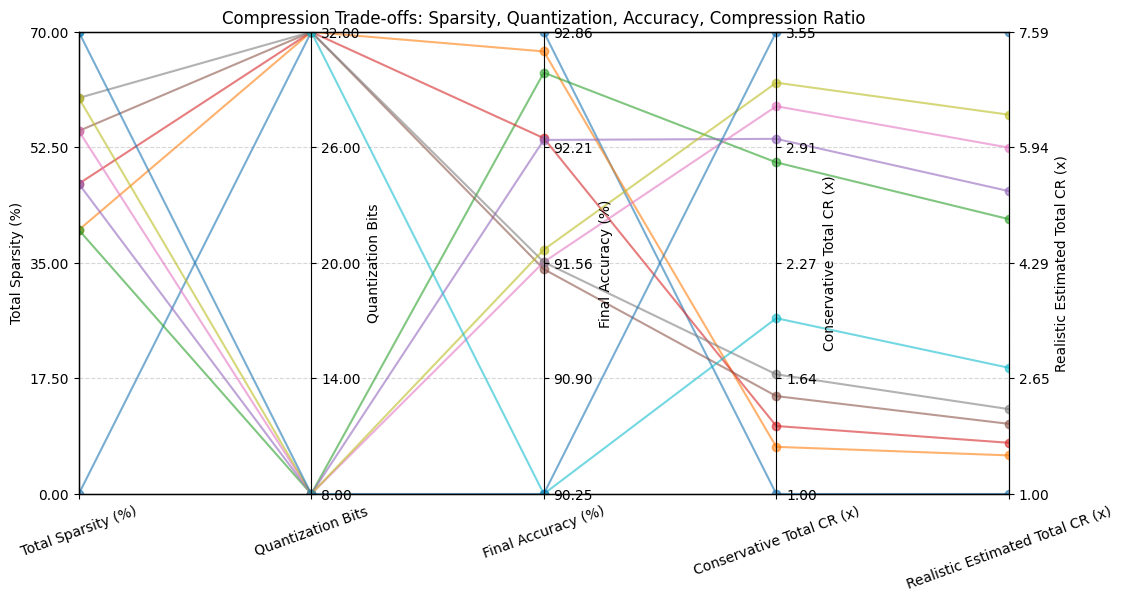

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = df_compression_results.copy()

cols = ["Total Sparsity (%)", "Quantization Bits", "Final Accuracy (%)", "Conservative Total CR (x)", "Realistic Estimated Total CR (x)"]
x = np.arange(len(cols))

fig, host = plt.subplots(figsize=(12,6))

# Base axis
host.set_xticks(x)
host.set_xticklabels(cols, rotation=20)
host.set_xlim(x[0], x[-1])
host.set_title("Compression Trade-offs: Sparsity, Quantization, Accuracy, Compression Ratio")
host.grid(True, linestyle="--", alpha=0.5)

axes = [host]
for i in range(1, len(cols)):
    ax_new = host.twinx()
    ax_new.spines["right"].set_position(("axes", i/(len(cols)-1)))
    axes.append(ax_new)

# Normalize each column to [0,1]
scalers = {}
for i, col in enumerate(cols):
    col_min, col_max = df[col].min(), df[col].max()
    scalers[col] = lambda y, cmin=col_min, cmax=col_max: (y - cmin) / (cmax - cmin)

# Plot each row across all axes
for _, row in df.iterrows():
    y_scaled = [scalers[col](row[col]) for col in cols]
    host.plot(x, y_scaled, marker="o", alpha=0.6)

# Put original scales on each axis
for i, col in enumerate(cols):
    col_min, col_max = df[col].min(), df[col].max()
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel(col)
    axes[i].set_yticks(np.linspace(0, 1, 5))
    axes[i].set_yticklabels([f"{v:.2f}" for v in np.linspace(col_min, col_max, 5)])

plt.savefig('./plots/wandb_plot.png')
plt.show()

In [26]:
final_pruned_model

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [27]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2

# Load model
model = mobilenet_v2()  
final_pruned_model = model  # if you already pruned

# Dummy input (ImageNet size)
x = torch.randn(1, 3, 224, 224)

layer_info = []
def hook_fn(module, input, output):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        num_neurons = output.numel()
        layer_info.append({
            "layer": str(module),
            "output_shape": list(output.shape),
            "neurons": num_neurons
        })

# Register hooks
hooks = []
for m in final_pruned_model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        hooks.append(m.register_forward_hook(hook_fn))

# Run dummy forward
with torch.no_grad():
    final_pruned_model(x)

# Remove hooks
for h in hooks:
    h.remove()

# Analyze results
import pandas as pd
df = pd.DataFrame(layer_info)
print(df)

print("\nTotal layers:", len(df))
print("Max neurons in a layer:", df['neurons'].max())

                                                layer       output_shape  \
0   Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2...  [1, 32, 112, 112]   
1   Conv2d(32, 32, kernel_size=(3, 3), stride=(1, ...  [1, 32, 112, 112]   
2   Conv2d(32, 16, kernel_size=(1, 1), stride=(1, ...  [1, 16, 112, 112]   
3   Conv2d(16, 96, kernel_size=(1, 1), stride=(1, ...  [1, 96, 112, 112]   
4   Conv2d(96, 96, kernel_size=(3, 3), stride=(2, ...    [1, 96, 56, 56]   
5   Conv2d(96, 24, kernel_size=(1, 1), stride=(1, ...    [1, 24, 56, 56]   
6   Conv2d(24, 144, kernel_size=(1, 1), stride=(1,...   [1, 144, 56, 56]   
7   Conv2d(144, 144, kernel_size=(3, 3), stride=(1...   [1, 144, 56, 56]   
8   Conv2d(144, 24, kernel_size=(1, 1), stride=(1,...    [1, 24, 56, 56]   
9   Conv2d(24, 144, kernel_size=(1, 1), stride=(1,...   [1, 144, 56, 56]   
10  Conv2d(144, 144, kernel_size=(3, 3), stride=(2...   [1, 144, 28, 28]   
11  Conv2d(144, 32, kernel_size=(1, 1), stride=(1,...    [1, 32, 28, 28]   
12  Conv2d(3

In [28]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v2
import pandas as pd

# Load model
model = mobilenet_v2()
final_pruned_model = model

# Dummy input
x = torch.randn(1, 3, 224, 224)

layer_info = []
def hook_fn(module, input, output):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        shape = list(output.shape)
        num_neurons = output.numel()
        
        # Handle Conv2d [B,C,H,W] and Linear [B,N]
        if isinstance(module, nn.Conv2d):
            batch, ch, h, w = shape
        elif isinstance(module, nn.Linear):
            batch, ch = shape
            h, w = 1, 1  # No spatial dimensions for Linear

        layer_info.append({
            "layer": str(module),
            "output_shape": shape,
            "neurons": num_neurons,
            "channels": ch,
            "height": h,
            "width": w
        })

# Register hooks
hooks = []
for m in final_pruned_model.modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        hooks.append(m.register_forward_hook(hook_fn))

# Run dummy forward
with torch.no_grad():
    final_pruned_model(x)

# Remove hooks
for h in hooks:
    h.remove()

# DataFrame
df = pd.DataFrame(layer_info)
print(df)

print("\nTotal layers:", len(df))
print("Max neurons in a layer:", df['neurons'].max())
print("Max channels:", df['channels'].max())
print("Max height:", df['height'].max())
print("Max width:", df['width'].max())

                                                layer       output_shape  \
0   Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2...  [1, 32, 112, 112]   
1   Conv2d(32, 32, kernel_size=(3, 3), stride=(1, ...  [1, 32, 112, 112]   
2   Conv2d(32, 16, kernel_size=(1, 1), stride=(1, ...  [1, 16, 112, 112]   
3   Conv2d(16, 96, kernel_size=(1, 1), stride=(1, ...  [1, 96, 112, 112]   
4   Conv2d(96, 96, kernel_size=(3, 3), stride=(2, ...    [1, 96, 56, 56]   
5   Conv2d(96, 24, kernel_size=(1, 1), stride=(1, ...    [1, 24, 56, 56]   
6   Conv2d(24, 144, kernel_size=(1, 1), stride=(1,...   [1, 144, 56, 56]   
7   Conv2d(144, 144, kernel_size=(3, 3), stride=(1...   [1, 144, 56, 56]   
8   Conv2d(144, 24, kernel_size=(1, 1), stride=(1,...    [1, 24, 56, 56]   
9   Conv2d(24, 144, kernel_size=(1, 1), stride=(1,...   [1, 144, 56, 56]   
10  Conv2d(144, 144, kernel_size=(3, 3), stride=(2...   [1, 144, 28, 28]   
11  Conv2d(144, 32, kernel_size=(1, 1), stride=(1,...    [1, 32, 28, 28]   
12  Conv2d(3